In [ ]:
!pip install -q datasets      #Asking pip package manager to install datasets library in quiet mode


In [ ]:
from datasets import load_dataset  #Impoting from datasets library the load_dataset function which loads datasets from Hugging face data library
emotions = load_dataset("emotion") # Asks load_dataset function to load emotion dataset from HF and assign it to the variable "emotions"

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [ ]:
emotions             #Printing the variable "emotions"


In [ ]:
train_set = emotions["train"]          # Assign the training split of the loaded emotion dataset to the variable train_set
train_set                              # Print

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [ ]:
train_set[100]             #Printing the 100th value in the train_set


In [ ]:
emotions.set_format(type="pandas")          # Convert the emotions' data format to be compatible to pandas data structure
df = emotions["train"][:]                   #Assign all the rows of emotions training set to pandas dataframe 'df' for data analytics using Pandas
df.head()                                   #Printing the first 5 df


In [ ]:
# The emotions are mentioned as numbers, we need to convert them strings

def label_converter(row):                         # Define label_converter(row) function. What will it do?
  return emotions["train"].features["label"].int2str(row) # It accesses the training split of emotions dataset, retrieves mets data of label
                                                          #features and converts integers to strings and returns them

In [ ]:
df["label_name"] = df["label"].apply(label_converter)  # Access every value in label column of df, apply label converter function
df.head()                                              # Store the string value in lable_name column

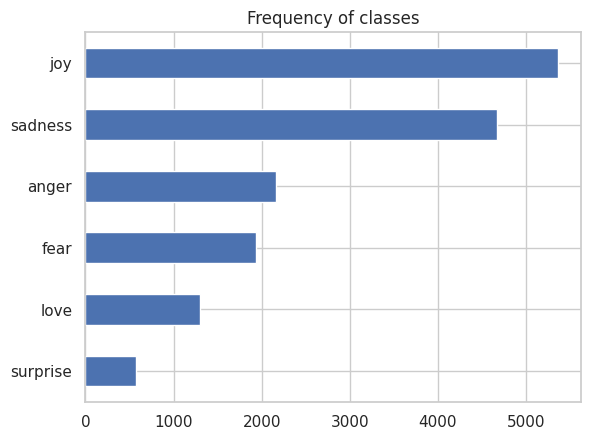

In [ ]:
# Print the frequency of emotions in the dataset
import matplotlib.pyplot as plt                # import the matplotlib.pyplot module and alias it as plt
import seaborn as sns                          # Import seaborn library used in drawing graphs. its a data visualization library
sns.set_theme(style="whitegrid")               # Sets a theme for below graph

df['label_name'].value_counts(ascending=True).plot.barh()  # Takes the all value in 'label_name' column in df training dataset
                                                           # Counts all the freq of all uniques values
                                                           # Puts all the values in ascending order in a bar graph
plt.title("Frequency of classes")                          # Set title of the plot
plt.show()                                                 # Show plot

In [ ]:
#This is an imbalanced dataset

emotions.reset_format()              # We converted the dataset format to pandas. Now, we reset it.

In [ ]:
# Data preprocessing
!pip install -q transformers         # Asking pip package manager to install Hugging face transformers in quiet mode


In [ ]:
# Load tokenizer: DistilBERT tokenizer
from transformers import AutoTokenizer            # Import the autotokenizer class from transformers library
checkpoint = "distilbert-base-uncased"            # Assigns the text dilbert-base-uncased, variant of BERT model, to the variable checkpoint
tokenizer = AutoTokenizer.from_pretrained(checkpoint) # Calling AutoTokenizer class which loads tokenizers from the pretrained model, checkpoint.

def tokenize_function(batch):              # Defining tokenize_function which takes batch of text input, and tokenizes it based on the definition
    return tokenizer(batch["text"], padding=True, truncation=True) # Calling tokenizer method for each text input in the input batch
                                                                   # Pad, truncate are parameters passed in the method tokenizer()
                                                                   # Pad: all inputs have same max length.
                                                                   # Trancation: truncate the larger ones to max length

In [ ]:
print(tokenize_function(emotions["train"][:5])) # Tokenize text data in first 5 samples of the training set (emotions["train"][:5]) using the tokenize_functio, and then print

In [ ]:
tokenized_datasets = emotions.map(tokenize_function, batched=True, batch_size=None)
# Applies tokenize_function to each batch of the dataset emotions using the map function

In [ ]:
print(tokenized_datasets["train"].column_names)  #Print column names of the toeknized train dataset

In [60]:
# Columns input_ids and attention_mask has been added to the dataset
# Building the model
from transformers import AutoModelForSequenceClassification #AutoModelForSequenceClassification class from the transformers library.
                                                # This class automatically loads a pre-trained model for sequence classification tasks
import torch                                    #This line imports the torch library, which is the main library used for tensor computations

checkpoint = "distilbert-base-uncased"  # The string represents the identifier of a pre-trained model Distilbert, distilled version of BERT
                                        # it is assigned to the variable checkpoint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # checks if a CUDA-enabled GPU is available on the system.
 # If a CUDA-enabled GPU is available, it assigns the device to CUDA (GPU), otherwise, it assigns it to CPU.
 # CUDA(Compute Unified Device Architecture) is a parallel computing platform and API model created by NVIDIA.
 #  It enables developers to harness the computational power of NVIDIA GPUs

#Using AutoModel.. class we are loading Distilbert model to GPU/CPU. num_labels specifies the classification tasks for fine tuning.
# num_label is set to 6 bcz we have 6 diff emotions in the dataset
model = (AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 6).to(device))



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
from sklearn.metrics import accuracy_score, f1_score  # Metrices for calculating model accuracy

def compute_metrics(pred):               # this method takes the predicted values and calculates and returns accuracy scores and F1 scores
  labels = pred.label_ids                # Retrieves true labels from the preedicted outputs
  preds = pred.predictions.argmax(-1)    # Calculates the pred label values and assigns it to variable 'pred'
  f1 = f1_score(labels, preds, average="weighted")  # F1 score using true labels and pred labels
  acc = accuracy_score(labels, preds)               # Accuracy score compares true labels and pred labels
  return {"Accuracy": acc, "F1": f1}           # Return acc, f1


In [ ]:
from huggingface_hub import notebook_login
notebook_login()                               #Login into Hugging face to access the models and datasets

In [62]:
!pip install accelerate==0.21.0

!pip install transformers[torch]          # Install transformers with support for Pytorch
from transformers import TrainingArguments # Import TrainingArguments class to customize training setings for training the model
# Create an instance of the TrainingArguments class and assign it to the train_args variable
train_args = TrainingArguments(
    # Specify the directory where the fine-tuned model and its associated files will be saved
    output_dir="finetuning-emotionsmodel",

    # Define the number of training epochs, which is the number of times the model will iterate over the entire training dataset during training
    num_train_epochs=2,

    # Set the learning rate for the optimizer. This is the rate at which the model parameters are updated during training
    learning_rate=0.00002,

    # Specify the batch size used during evaluation (on the validation dataset) on each device (GPU or CPU)
    per_device_eval_batch_size=64,

    # Specify the batch size used during training on each device
    per_device_train_batch_size=64,

    # Specify the amount of weight decay to apply as a regularization technique to prevent overfitting
    weight_decay=0.01,

    # Determine when to evaluate the model's performance on the validation dataset. Here, it's set to "epoch," meaning evaluation will be performed after each training epoch
    evaluation_strategy="epoch",

    # Determine whether to disable the tqdm progress bar during training
    disable_tqdm=False,

    # Determine whether to push the fine-tuned model to the Hugging Face model hub after training
    push_to_hub=True
)


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

In [ ]:
from transformers import Trainer     # Import Trainer class which customizes the training process by assiging training parameters.
trainer = Trainer(
    model = model,
    args = train_args,
    compute_metrics = compute_metrics,
    train_dataset = tokenized_datasets["train"],
    eval_dataset = tokenized_datasets["validation"],
    tokenizer = tokenizer
)

In [ ]:
#Fine tuning the model
trainer.train()                       #Creating instance for Trainer class

In [ ]:
trainer.push_to_hub(commit_message ="Training completed")       #Push to hub

In [ ]:
from transformers import pipeline

classifier = pipeline("text-classification",           # Calling pipeline function of text-classification type and specifying the model to use
                       model = "Sidasthana2212/finetuning-emotionsmodel") # passing the input text to the model

In [ ]:
pred = classifier(["Bhenchod"],                       # Passing the input to classifier which calls the pipelines above
                  return_all_scores = True)

import pandas as pd
labels = emotions["train"].features["label"].names # takes the train dataset, finds label feature names and assigns to label variable
df = pd.DataFrame(pred[0])  # Pred[0] contains predicted data; pd.DataFrame() class creates dataframes for pandas.
                            # This command converts predictions into dataframes to be used by pandas to plot the graph
plt.bar(labels, 100*df["score"]) #plt.bar() creates bar graph; show labels in the emotion data, 100 is height of the bars in the plot
plt.show()